In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator, manhattandistance
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
sub = 1
Sx = Sy = int(((512 - 1) / sub) + 1)
maps = np.load('/mountvol/2D-512-Dataset-0/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
# maps = maps[30:31,:,:].reshape(1,Sx,Sy)

Generate Random Start and Goal Positions on Maps

In [3]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

Comparing Euclidean and Manhattan Distance

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=True)


Testing Euclidean Norm
Average Path Cost: 318.40741105089893 
Average Planning Time: 0.9740548849105835 
Average Inference Time: 0.007828011512756347 
Average Number of Node Expansions: 15741.52 
Average Success Rate: 1.0


In [5]:
# Manhattan Distance
print("Testing Manhattan Distance")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, manhattandistance, plotresults=False, printvalues=True)

Testing Manhattan Distance
Average Path Cost: 323.4034500202199 
Average Planning Time: 0.17350224971771241 
Average Inference Time: 0.002386045455932617 
Average Number of Node Expansions: 2718.44 
Average Success Rate: 1.0


Planning Operator

In [6]:
# Model
modes = 8
width = 24
nlayers = 1

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/2D-512-Dataset-0/planningoperator_street_maps_512x512_8m_12w_1l_b20/n500_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model256.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []



/tmp/ipykernel_11377/697047691.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/2D-512-Dataset-0/planningoperator_street_maps_

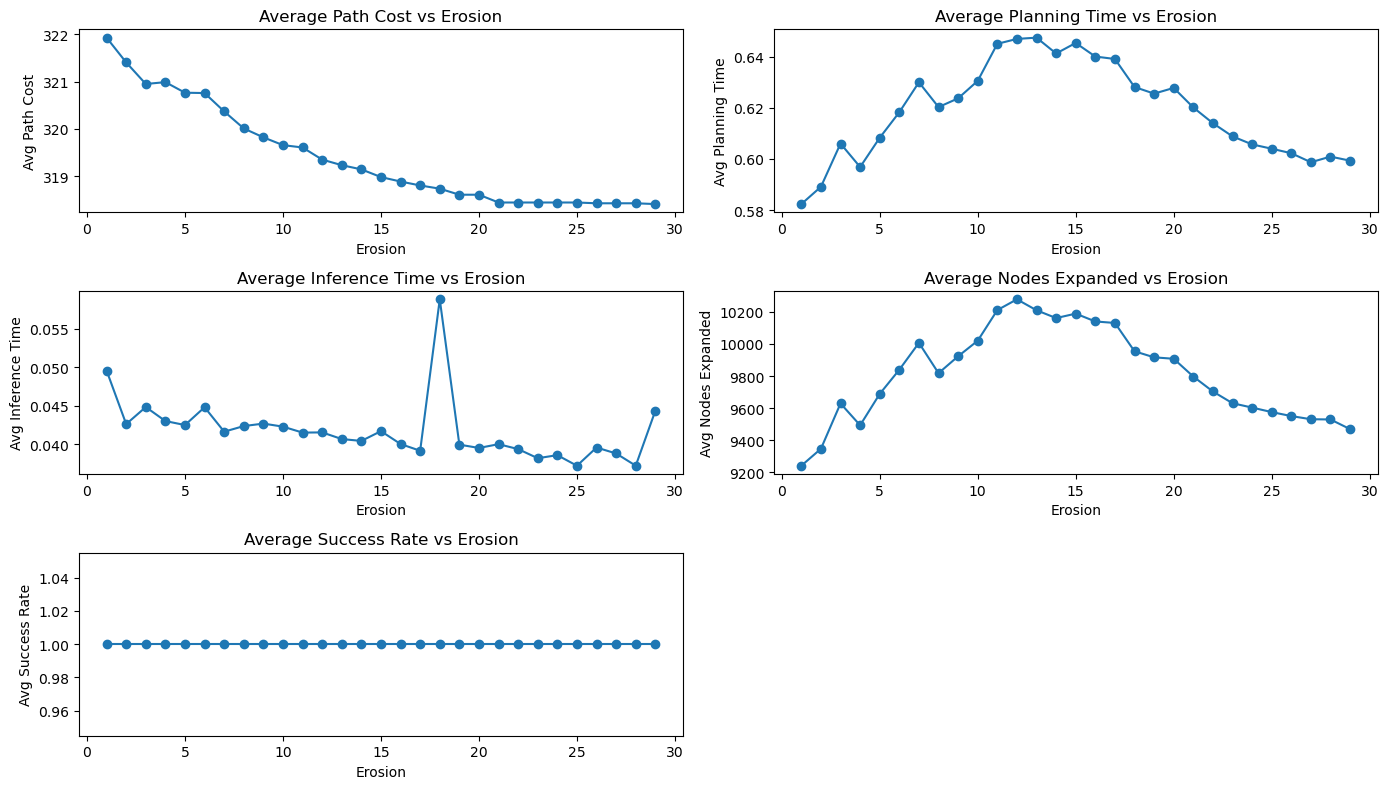

In [7]:

# Run the loop and store results
for erode in range(1, 30):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        startpositions, goalpositions, maps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

# Plotting the results
plt.figure(figsize=(14, 8))

# Plot for avgpathcost
plt.subplot(3, 2, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Cost vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Cost')

# Plot for avgplantime
plt.subplot(3, 2, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avginfertime
plt.subplot(3, 2, 3)
plt.plot(erosion_values, avginfertime_values, marker='o')
plt.title('Average Inference Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Inference Time')

# Plot for avgnodesexp
plt.subplot(3, 2, 4)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

# Plot for avgsuccessrate
plt.subplot(3, 2, 5)
plt.plot(erosion_values, avgsuccessrate_values, marker='o')
plt.title('Average Success Rate vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Success Rate')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [8]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 20, model=model)

Testing PNO
Average Path Cost: 318.6054009496313 
Average Planning Time: 0.6246461343765258 
Average Inference Time: 0.03788289546966553 
Average Number of Node Expansions: 9907.72 
Average Success Rate: 1.0


In [9]:
# Store startpositions(np.array), goalpositions(np.array), maps(np.array), model(.ckpt), euclidean_results(list), no_results(list)
import pickle
# Store everything in a dictionary
data = {
    "startpositions": startpositions,
    "goalpositions": goalpositions,
    "maps": maps,
    "model": model,
    "euclidean_results": euclidean_results,
    "no_results": no_results,
    "erosion_values": erosion_values,
    "avgpathcost_values": avgpathcost_values,
    "avgplantime_values": avgplantime_values,
    "avginfertime_values": avginfertime_values,
    "avgnodesexp_values": avgnodesexp_values,
    "avgsuccessrate_values": avgsuccessrate_values
}

# Save to file using pickle
with open("512maps.pkl", "wb") as file:
    pickle.dump(data, file)

print("Data saved successfully to '512maps.pkl'")

Data saved successfully to '512maps.pkl'
